In [ ]:

import numpy as np 
import pandas as pd 
import wordcloud
import matplotlib.pyplot as plt 
import re
import io 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
from keras.layers import Dense, Embedding, LSTM,SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud,STOPWORDS
from google.colab import files 
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from google.colab import files

In [ ]:


from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
df = pd.read_csv("drive/My Drive/sentiment.csv", encoding='latin-1',names=["class","com_no","date","unnamed","topic","comments"])

In [ ]:
df[np.isnan(df["class"])]

,class,com_no,date,unnamed,topic,comments


In [ ]:
df['word_count'] = df['comments'].apply(lambda x : len(str(x).split(" ")))
df['char_count'] = df['comments'].str.len()

In [ ]:
print("words after removing duplicates and before filter   ",df["word_count"].sum())
print( "characters after removing duplicates and before filter  ",df["char_count"].sum())
print("length of class {} and length of comments is {}".format(len(df["class"]),len(df["comments"])))

words after removing duplicates and before filter    23011409
characters after removing duplicates and before filter   118544178
length of class 1600000 and length of comments is 1600000


In [ ]:
df = df.drop(df.columns[df.columns.str.contains("unnamed",case=False)],axis=1)
df = df.drop(df.columns[df.columns.str.contains("com_no",case=False)],axis=1)

In [ ]:
df.describe()

,class,word_count,char_count
count,1.600000e+06,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.438213e+01,7.409011e+01
std,2.000001e+00,7.062139e+00,3.644114e+01
min,0.000000e+00,2.000000e+00,6.000000e+00
25%,0.000000e+00,9.000000e+00,4.400000e+01
50%,2.000000e+00,1.300000e+01,6.900000e+01
75%,4.000000e+00,2.000000e+01,1.040000e+02
max,4.000000e+00,1.100000e+02,3.740000e+02


In [ ]:
df["class"].unique()

array([0, 4])

In [ ]:

freq_word = pd.Series(' '.join(df['comments']).split()).value_counts()
freq_word[-5:]

RELATE                          1
OS,fast,800x480screen&amp;BB    1
@jmegs8                         1
unc!!!                          1
@archininja)                    1
dtype: int64

In [ ]:
df["class"] = df["class"].replace(4,1)

In [ ]:
df["class"][-10:]

1599990    1
1599991    1
1599992    1
1599993    1
1599994    1
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: class, dtype: int64

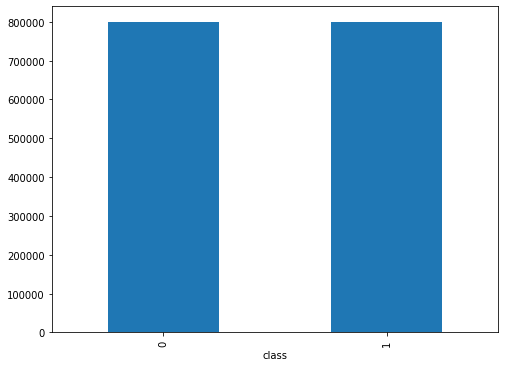

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(8,6))
df.groupby('class').comments.count().plot.bar(ylim=0)
plt.show()

In [ ]:
df[["comments","class"]] = df[["comments","class"]].drop_duplicates()

In [ ]:
df['word_count'] = df['comments'].apply(lambda x : len(str(x).split(" ")))
df['char_count'] = df['comments'].str.len()

In [ ]:
print("words after removing duplicates and before filter   ",df["word_count"].sum())
print( "characters after removing duplicates and before filter  ",df["char_count"].sum())
print("length of class {} and length of comments is {}".format(len(df["class"]),len(df["comments"])))

words after removing duplicates and before filter    22908469
characters after removing duplicates and before filter   117950871.0
length of class 1600000 and length of comments is 1600000


In [ ]:

#after removing duplicates
df[np.isnan(df["class"])]

,class,date,topic,comments,word_count,char_count
1940,NaN,Tue Apr 07 00:38:38 PDT 2009,ei8htyOne,NaN,1,NaN
2149,NaN,Tue Apr 07 00:56:00 PDT 2009,Augustina22CA,NaN,1,NaN
3743,NaN,Tue Apr 07 03:02:08 PDT 2009,FranciscoAndre,NaN,1,NaN
3746,NaN,Tue Apr 07 03:02:17 PDT 2009,ammaryasir,NaN,1,NaN
4163,NaN,Tue Apr 07 03:33:56 PDT 2009,lkm1989,NaN,1,NaN
...,...,...,...,...,...,...
1599450,NaN,Tue Jun 16 08:28:39 PDT 2009,asiatikah,NaN,1,NaN
1599501,NaN,Tue Jun 16 08:28:49 PDT 2009,_cammi_,NaN,1,NaN
1599531,NaN,Tue Jun 16 08:30:28 PDT 2009,majaricious,NaN,1,NaN
1599678,NaN,Tue Jun 16 08:32:47 PDT 2009,ShaneLemmon,NaN,1,NaN


In [ ]:
#length before preprocessing
count = 0
for word in df["comments"][0].split(" "):
    count += 1
print(count)

20


In [ ]:
len(df["comments"])

1600000

In [ ]:
df = df.dropna()

In [ ]:
#length of comments after dropping Nan
df.comments.count()

1583691

In [ ]:
df['word_count'] = df['comments'].apply(lambda x : len(str(x).split(" ")))
df['char_count'] = df['comments'].str.len()

In [ ]:
#character before applying filter
print("words after removing duplicates and before filter   ",df["word_count"].sum())
print( "characters after removing duplicates and before filter  ",df["char_count"].sum())
print("length of class {} and length of comments is {}".format(len(df["class"]),len(df["comments"])))

words after removing duplicates and before filter    22892160
characters after removing duplicates and before filter   117950871
length of class 1583691 and length of comments is 1583691


In [ ]:
dict_1= {"be" :("was", "were","been"),
"beat":("beat","beaten"),
"become":("became","become"),
"begin":("began","begun"),
"bend":("bent","bent"),
"bet":("bet","bet"),
"bid":("bid","bid"),
"bite":("bit","bitten"),
"blow":("blew","blown"),
"break":("broke","broken"),
"bring":("brought","brought"),
"build":("built","built"),
"swim":("swam","swum"),
"take":("took","taken"),
"teach":("taught","taughts"),
"tear":("tore","torn"),
"fuck" : ("f***","****","f**k","f*ck","*uck","***k","fucks","fucking","f***s"),
"suck" : ("s***","s**k","s*ck","su*k","sucking","sucks","s***s"),
"shit" : ("s**t","***t","s*it","sh*t","bullsh*t"),
"bitch" : ("b*tch","b***h","b****","b*tch","*****","bitc*","bi*ch","*****h","bitches"),
"asshole"   : ("asshole","ass","assholes","a**"),
"wrank" : ("w***k","wr**k","w*ank","wra*k"),
"dick" : ("d**k","d*ck","di*k","d***"),
"piss"  : ("pissed","pissedoff"),
"tell":("told","tolds","tel"),
"think":("thoughts","thought"),
"throw":("threw","thrown"),
"understand":("understoods","understood"),
"wake":("woke","woken"),
"wear":("wore","worn"),
"win":("wons","won"),
"write":("wrote","written"),
"talent":("talents","talented"),
"you"  : ("u"),
"wait" : ("w8","waitings"),
"right" : ("r8","rights"),
"nice"  : ("9ce","nyc"),
"great"  : ("gr8","greats"),
"nice" : ("9ce","9c"),
"still" : ("stil"),
"ill"  : ("il"),
"your" : ("ur"),
"year" : ("yrs","yr","years"),
"boyfriend" : ("boyfriends","bf"),
"girlfriend" : ("girlfriends","gf"),
"till" : ("til")}

In [ ]:
#my own lemma and word filter
'''this function will remove any type of didgit or comma or dot or 
brackets etc from sentences whether is in between word,in start or in end  and
 also recognioze abuse from sterics(*) and  will remove more two same char from word like 
 booooooooooring will replace with booring and word sleepiiiiiiiiiiing will replace with sleepiing '''
def my_lemma(d,w):
    for key,value in d.items():
           for j in value:
                if j==w:
                    return (key)
    return w
def filter1(comm,start_num=["9ce","9c"] ,end_num=["w8","r8","gr8"],single_words=["a","i","u"],list1= ["well","class","hell","all","bell","will","chill","mill","miss","ass","piss"],abuses=["b*tch","b***h","b****","b*tch","*****","bitc*","bi*ch","s**t","***t","s*it","s***","s**k","s*ck","su*k","f***","****","f**k","f*ck","*uck","f*ck","f**ks","f***s","w****","w***k","d***","d**k","d*ck","di*k","***k","sh*t","bullsh*t"]):
    d = []
    for i in start_num:
        if i not in single_words:
            if len(i)<3:
                single_words.append(i)
    for i in end_num:
        if i not in single_words:
            if len(i)<3:
                single_words.append(i)
        
    for com in comm:
        s = str(com.lower()).split()
        c = []
        for word in s:
            if len(word)>2:
                    for i in range(len(word)):
                        try:
                            if word.isdigit() or word[0:3]=="amp" or word[0:4] =="(gmt" or word[0:4] =="(Gmt" or word[0:3] =="GMT" or word[0:3] =="gmt" or word[0:3] =="Gmt" or word == "pm" or word[0] == "@"  or word[0:5] == "&quot" or word[0:4] == "quot" or word[0:4] == "http" or word[0] == ";"  or word == "RT" or word =="rt" or word[0:4] == "www."  :
                                pass
                            elif (word[0].isdigit()) and (word[-2:]=="pm"  or word[-3:]=="pm." or word[-3:]=="am." or word[-3:]=="pm," or word[-3:]=="am,"):
                                pass
                            elif word[0]=="*" and word[-1] == "*" and len(word)>5:
                                pass
                                break
                            elif word in abuses:
                                word = word
                                break
                            elif (not word[0].isalpha()) and (not word[-1].isalpha()):
                                word = word[1:-1]
                            elif (word[0].isalpha()) and ( not word[-1].isalpha()) and (word not in end_num):
                                word = word[:-1]
                            elif (not word[0].isalpha()) and (word[-1].isalpha() and (word not in start_num)):
                                word = word[1:]
                            else:
                                if word.isalpha():
                                    word = word
                                else:
                                    pass
                                break
                        except IndexError:
                            pass
                    tempo = []    
                    for i in range(len(word)):
                        tempo.append(word[i])
                        if len(tempo)>=3:
                            if (tempo[-3]==tempo[-2]) and (tempo[-2]==tempo[-1]) and(tempo[-1]!="*"):
                                tempo.pop()
                            else:
                                pass
                    word = "".join(tempo)    
            if (word not in list1) and (len(word) > 2 )and (not word.isdigit()) :   
                for i in range(len(word)):
                    if word[0]=="*" and word[-1] == "*" and len(word)>5:
                            pass
                            break
                    elif (word[-2] == word[-1]) and (len(word) >2) and (word not in abuses) :
                        word = word[:-1]
                        if word in list1:
                            word = word
                            break
                    elif (word[0] == word[1]) and (len(word) >2) and (word not in abuses) :
                        word = word[1:]
                        if word in list1:
                            word = word
                            break
                    else:
                        word=word
                        break        
                if (word[-1] == "." or word[-1].isdigit()  or word[-1] == "," or word[-1] == "\\" or word[-1] == "/"  or word[-1] == "-" or word[-1] == "+" or word[-1] == "?" or word[-1] == "!"  or word[-1]=="(" or word[-1]=="{" or word[-1]=="[" or word[-1]==")" or word[-1]=="}" or word[-1]=="]"or word[-1]=="<" or word[-1] == ">" ) and (len(word) > 2) and (word not in abuses) and (word not in end_num) and (word not in start_num):
                    word = word[:-1]
                    if word[-2] == word[-1] and len(word) > 2 :
                        for i in range(len(word)):
                            if (word[-2] == word[-1] and len(word) >2 and word[0].isalpha()):
                                word = word[:-1]
                            else:
                                word=word
                                break
                else:
                    word=word   
                if word.isdigit() or word[0:3]=="amp" or word[0:4] =="(gmt" or word[0:4] =="(Gmt" or word[0:3] =="GMT" or word[0:3] =="gmt" or word[0:3] =="Gmt" or word == "am" or word == "pm" or word[0] == "@"  or word[0:5] == "&quot" or word[0:4] == "quot" or word[0:4] == "http" or word[0] == ";" or word[0] == "-" or word[0] == " " or word == "RT" or word =="rt" or word[0:4] == "www." or word=="(" or word=="{" or word=="[" or word==")" or word=="}" or word=="]"or word=="<" or word == ">" :
                    pass
                elif (word[0].isdigit()) and (word[-2:]=="pm"  or word[-3:]=="pm." or word[-3:]=="am." or word[-3:]=="pm," or word[-3:]=="am,"):
                        pass
                else:
                    if (word in abuses) or (word in end_num) or (word in start_num):
                        word = word
                        if word[0]=="*" and word[-1] == "*" and len(word)>5:
                            pass
                        else:
                            c.append(my_lemma(dict_1,word))
                    elif (word[0]=="," or word[0]=="." or word[0]=="!" or word[0]=="?" or word[0]=="+" or word[0]=="-" or word[0]=="*"  or word[0]=="(" or word[0]=="{" or word[0]=="[" or word[0]==")" or word[0]=="}" or word[0]=="]" or word[0].isdigit() or word[0]=="<" or word[0] == ">") and (word[-1]=="<" or word[-1] == ">" or word[-1]=="," or word[-1]=="." or word[-1]=="!" or word[-1]=="?" or word[-1]=="+" or word[-1]=="-" or word[-1]=="*"  or word[-1]=="(" or word[-1]=="{" or word[-1]=="[" or word[-1]==")" or word[-1]=="}" or word[-1]=="]" or word[-1].isdigit()): 
                        temp = word[1:-1]
                        if temp.isalpha():
                            c.append(my_lemma(dict_1,temp))
                        else:
                            pass
                    else:
                        if (word[-1] == "." or word[-1].isdigit()  or word[-1] == "," or word[-1] == "\\" or word[-1] == "/"  or word[-1] == "-" or word[-1] == "+" or word[-1] == "?" or word[-1] == "!"  or word[-1]=="(" or word[-1]=="{" or word[-1]=="[" or word[-1]==")" or word[-1]=="}" or word[-1]=="]"or word[-1]=="<" or word[-1] == ">" )  and (not word[0].isdigit() and word[0] != ";" and word[0] != "-" and word[0] != " " and  word[0]!="(" and word[0]!="{" and word[0]!="[" and word[0]!=")" and word[0]!="}" and word[0]!="]" and word[0]!="<" and word[0] != ">" and len(word)>2):
                            temp1=word[:-1]
                            if temp1.isalpha():
                                c.append(my_lemma(dict_1,temp1))
                            else:
                                pass
                        elif word[0] == "." or word[0].isdigit()  or word[0] == ","or word[0]=="(" or word[0]=="{" or word[0]=="[" or word[0]==")" or word[0]=="}" or word[0]=="]"or word[0]=="<" or word[0] == ">"  or word[0]=="#" or  word[0] == "\\" or word[0] == "/" or word[0] == "*" or word[0] == "-" or word[0] == "+" or word[0] == "?" or word[0] == "!":
                            temp1=word[1:]
                            if temp1.isalpha():
                                c.append(my_lemma(dict_1,temp1))
                            else:
                                pass
                        else:
                            temp1 = ""
                            for char in word:
                                if char.isalpha():
                                    temp1 += char
                            c.append(my_lemma(dict_1,temp1))
            else:
                try:   
                    if (word.isdigit() or word[0:3]=="amp" or word[0:4] =="(gmt" or word[0:4] =="(Gmt" or word[0:3] =="GMT" or word[0:3] =="gmt" or word[0:3] =="Gmt"  or word == "pm" or word[0] == "@"  or word[0:5] == "&quot" or word[0:4] == "quot" or word[0:4] == "http" or word[0] == ";" or word[0] == "-" or word[0] == " " or word == "RT" or word =="rt" or word[0:4] == "www." or word=="(" or word=="{" or word=="[" or word==")" or word=="}" or word=="]"or word=="<" or word == ">"):
                        pass
                    elif (word[0].isdigit()) and (word[-2:]=="pm" or word[-2:]=="am"  or word[-3:]=="pm." or word[-3:]=="am." or word[-3:]=="pm," or word[-3:]=="am,"):
                        pass
                    else:
                        if (not word[0].isalpha()) and (not word[-1].isalpha()): 
                            temp = word[1:-1]
                            if temp.isalpha():
                                c.append(my_lemma(dict_1,temp))
                            else:
                                pass
                        else:
                            if (word[0].isalpha()) and (not word[-1].isalpha()) and (word not in single_words):
                                temp1=word[:-1]
                                if temp1.isalpha():
                                    if len(temp1)>1:
                                        c.append(my_lemma(dict_1,temp1))
                                else:
                                    pass
                            elif (not word[0].isalpha()) and (word[-1].isalpha()) and (word not in single_words)  :
                                temp1=word[1:]
                                if temp1.isalpha():
                                    if len(temp1)>1:
                                        c.append(my_lemma(dict_1,temp1))
                                else:
                                    pass
                            else:
                                temp1 = ""
                                if word != "am" :
                                    if (len(word)>1) and (word not in single_words) :
                                        for char in word:
                                            if char.isalpha():
                                                temp1 += char
                                        c.append(my_lemma(dict_1,temp1))
                                    else:
                                        if word in single_words:
                                            c.append(my_lemma(dict_1,word))
                                        else:
                                            pass
                                else:
                                    if (c[-1] == "i") and  (word=="am"):
                                        c.append(word)
                                    else:
                                        pass
                except IndexError:
                      pass
        d.append(" ".join(c))
    return d

In [ ]:
l = df["comments"] 
print(l[0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [ ]:
#kength of first comment before preprocessing
count = 0
for word in l[0].split(" "):
    count += 1
print(count)

20


In [ ]:
comments2 = filter1(l)

In [ ]:
#length of firsts comment after preprocessing
count = 0
for comm in comments2[0]:
    for word in comm.split(" "):
        count +=1
    
print(count)

79


In [ ]:
# comments2 = []
# for com in comments1:
#     comments2.append(com[0].lower())

In [ ]:
df["comments"] = comments2

In [ ]:
df['word_count'] = df['comments'].apply(lambda x : len(str(x).split(" ")))
df['char_count'] = df['comments'].str.len()

In [ ]:
print("words after removing duplicates and before filter   ",df["word_count"].sum())
print( "characters after removing duplicates and before filter  ",df["char_count"].sum())
print("length of class {} and length of comments is {}".format(len(df["class"]),len(df["comments"])))

words after removing duplicates and before filter    19479465
characters after removing duplicates and before filter   99532280
length of class 1583691 and length of comments is 1583691


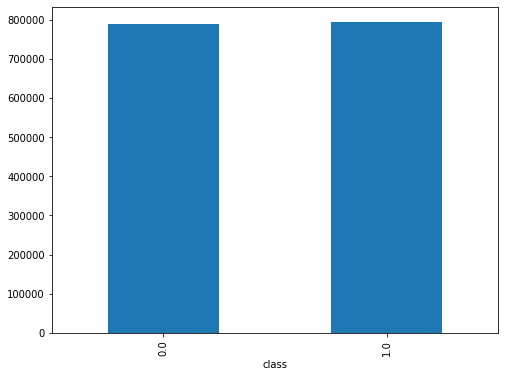

In [ ]:
fig = plt.figure(figsize=(8,6))
df.groupby('class').comments.count().plot.bar(ylim=0)
plt.show()

In [ ]:
freq1 =  pd.Series(' '.join(df['comments']).split()).value_counts()[:5]
freq1

still    744487
to       627042
the      518604
a        375019
you      319578
dtype: int64

In [ ]:
stopwords = set(STOPWORDS)
s1 = {"still",}
stopwords = stopwords.union(s1)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download("wordnet")
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Positive words


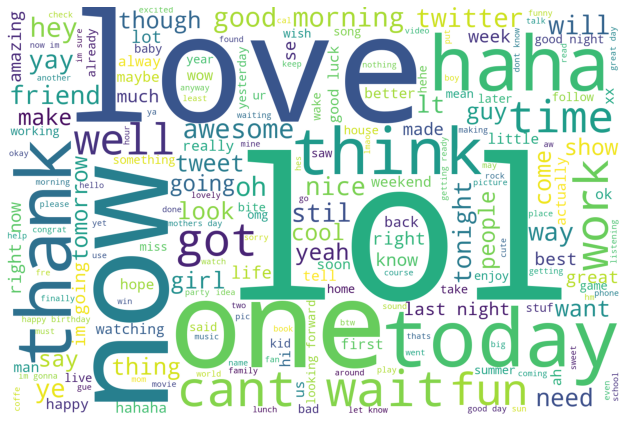

Negative words


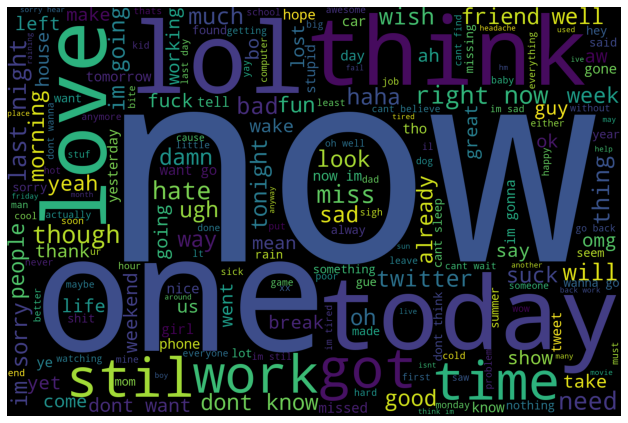

In [ ]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=stopwords,
                      background_color=color,
                      width=1500,
                      height=1000
                     ).generate(words)
    plt.figure(1,figsize=(11, 11))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
df_pos =  df.loc[df["class"]== 1,["comments"]]
df_neg =  df.loc[df["class"]== 0,["comments"]]
wordcloud_draw(list(df_pos["comments"]),'white')
print("Negative words")
wordcloud_draw(list(df_neg["comments"]))



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [ ]:
temp = df.groupby('class').count()['comments'].reset_index().sort_values(by='comments',ascending=False)
temp.style.background_gradient(cmap='Purples')

,class,comments
1,1.000000,793506
0,0.000000,790185


In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp["class"],
    values = temp.comments,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [ ]:
df.head()

In [ ]:
df_pos =  df.loc[df["class"]== 1,["word_count"]]
df_neg =  df.loc[df["class"]== 0,["word_count"]]
hist_data = [df_pos["word_count"] ,df_neg["word_count"] ]

group_labels = ['positive', 'Negative']


fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

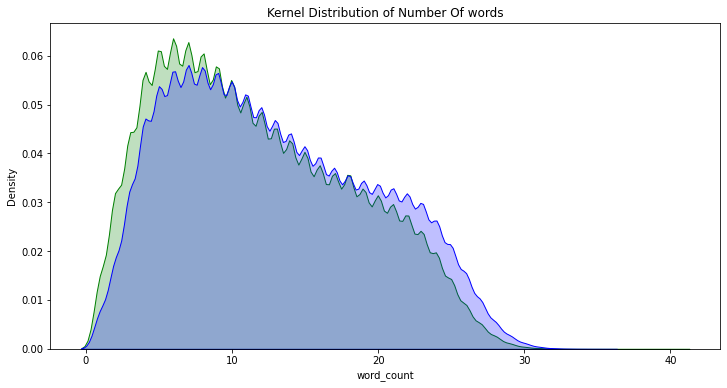

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df_pos['word_count'], shade=True, color="g").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(df_neg['word_count'], shade=True, color="b")

In [ ]:
from collections import Counter
df['temp_list'] = df['comments'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,still,744487
1,to,627042
2,the,518604
3,a,375019
4,you,319578
5,my,312088
6,and,297914
7,be,274199
8,is,234804
9,it,230686


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
!pip install --upgrade plotly

In [ ]:

fig = px.treemap(temp, labels =  ['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [ ]:
def lem_stem_stop(comms1):
    comments3 = []
    not_word = ["not","havent","hasnt","isnt","doesnt","dont","shouldnt","cant","wasnt","like"]
    for com in comms1:
        temp = []
        com=word_tokenize(com)
        for word in com:
          if word not in not_word: 
              s_word =stemmer.stem(word)
              l_word = lemmatizer.lemmatize(s_word)
              if l_word not in stopwords:
                  temp.append(l_word)
              else:
                  pass
          else:
              temp.append(word)
        comments3.append(" ".join(temp))
    return comments3    


In [ ]:

comments3 = lem_stem_stop(comments2)
comments3[:20]

['aw bummer shoulda got david car third day',
 'upset cant updat hi facebook text might cri result school today blah',
 'dive mani time bal manag save rest go bound',
 'whole bodi feel itchi like fire',
 'not behav im mad whi becaus cant se',
 'not whole crew',
 'need hug',
 'hey long time se ye rain bite onli bite lol im fine thank',
 'nope didnt',
 'que muera',
 'spring break plain citi snow',
 'repierc ear',
 'couldnt bear watch think ua lo embarrass',
 'count idk whi either never talk anymor',
 'wouldv first didnt gun not realli though zac snyder doucheclown',
 'wish got watch miss premier',
 'holli death scene will hurt sever watch film wri director cut not now',
 'file tax',
 'ah ive alway want se rent love soundtrack',
 'oh dear drink forgotten tabl drink']

In [ ]:
df["comments"]= comments3

In [ ]:
df['word_count'] = df['comments'].apply(lambda x : len(str(x).split(" ")))
df['char_count'] = df['comments'].str.len()

In [ ]:
#comments after removing stop words,duplicates,dict_words and filter 
print("words after removing duplicates and before filter   ",df["word_count"].sum())
print( "characters after removing duplicates and before filter  ",df["char_count"].sum())
print("length of class {} and length of comments is {}".format(len(df["class"]),len(df["comments"])))

words after removing duplicates and before filter    11458536
characters after removing duplicates and before filter   61695513
length of class 1583691 and length of comments is 1583691


In [ ]:
df.head()

,class,date,topic,comments,word_count,char_count,temp_list
0,0.0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,aw bummer shoulda got david car third day,8,41,"[aw, thats, a, bummer, you, shoulda, got, davi..."
1,0.0,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,upset cant updat hi facebook text might cri re...,12,68,"[is, upset, that, he, cant, update, his, faceb..."
2,0.0,Mon Apr 06 22:19:53 PDT 2009,mattycus,dive mani time bal manag save rest go bound,9,43,"[still, dived, many, times, for, the, bal, man..."
3,0.0,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,whole bodi feel itchi like fire,6,31,"[my, whole, body, feels, itchy, and, like, its..."
4,0.0,Mon Apr 06 22:19:57 PDT 2009,Karoli,not behav im mad whi becaus cant se,8,35,"[no, its, not, behaving, at, all, im, mad, why..."


In [ ]:
df["word_count"].max()

36

In [ ]:
max_fatures = 5000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(comments3)
X = tokenizer.texts_to_sequences(comments3)
X = pad_sequences(X)

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
# vec = TfidfVectorizer(min_df=10)
# X_train_vec = vec.fit_transform(comments3)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)


In [ ]:
#Y = pd.get_dummies(df['class']).values
Y = df["class"]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20,shuffle=True,random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1266952, 35) (1266952,)
(316739, 35) (316739,)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM,Conv1D,Flatten,SimpleRNN,MaxPooling1D,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
embed_dim = 64
lstm_out = 100
input_dim = len(tokenizer.word_index) + 1
input_length = X_train.shape[1]
model = Sequential()
model.add(Embedding(input_dim, 50, input_length = input_length))
model.add(Conv1D(padding = "same", kernel_size = 3, filters = 32, activation = "relu"))
model.add(MaxPooling1D(pool_size = 2))
model.add(LSTM(100))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, LSTM,Conv1D,Flatten,SimpleRNN,MaxPooling1D,Bidirectional
# from tensorflow.keras.callbacks import EarlyStopping
# embed_dim = 64
# lstm_out = 100
# input_dim = len(tokenizer.word_index) + 1
# input_length = X_train.shape[1]
# model = Sequential()
# model.add(Embedding(5000, 64, input_length = input_length))
# model.add(Conv1D(filters=32,kernel_size=(2),activation="relu"))
# model.add(Bidirectional(LSTM(64,recurrent_initializer="orthogonal")))
# model.add(Dense(50,activation="relu"))
# model.add(Dense(3,activation="relu"))
# model.add(Dense(1,activation = 'sigmoid'))
# model.compile(loss = 'binary_crossentropy', optimizer = 'AdaGrad', metrics = ['accuracy'])#adam
# print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 64)            320000    
                                                                 
 conv1d (Conv1D)             (None, 34, 32)            4128      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                        

In [ ]:
batch_size = 1000
model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size,validation_split=0.1, verbose = 1)

1141/1141 [==============================] - 641s 560ms/step - loss: 0.4727 - accuracy: 0.7733 - val_loss: 0.4488 - val_accuracy: 0.7884


In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
model.save("sentiment_model.h5")

In [ ]:
import re
import string
import pickle
from tensorflow.keras.models import load_model
import nltk
nltk.download('punkt')
nltk.download("wordnet")
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()
stopwords = set(STOPWORDS)
s1 = {"still",}
stopwords = stopwords.union(s1)
def lem_stem_stop(comms1):
    comments3 = []
    not_word = ["not","havent","hasnt","isnt","doesnt","dont","shouldnt","cant","wasnt","like"]
    for com in comms1:
        temp = []
        com=word_tokenize(com)
        for word in com:
          if word not in not_word: 
              s_word =stemmer.stem(word)
              l_word = lemmatizer.lemmatize(s_word)
              if l_word not in stopwords:
                  temp.append(l_word)
              else:
                  pass
          else:
              temp.append(word)
        comments3.append(" ".join(temp))
    return comments3    
def Predict(text,filepath="sentiment_model.h5"):
  l = []
  for d in text:
    document_test = re.sub(r'[^\x00-\x7F]+', ' ', d)
    document_test = re.sub(r'@\w+', '', document_test)
    document_test = document_test.lower()
    document_test = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', document_test)
    document_test = re.sub(r'[0-9]', '', document_test)
    document_test = re.sub(r'\s{2,}', ' ', document_test)
    l.append(document_test)
  text = lem_stem_stop(l)
  with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
  X = tokenizer.texts_to_sequences(text)

  X = pad_sequences(X,maxlen=35)
  model = load_model(filepath)
  y = model.predict(X)
  labels = ['Pos' if x>=0.50 else 'neg' for x in y ]
  confidence = [x if x>=0.50 else (1-x) for x in y ]
  return labels,confidence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
Predict(["I am not happy"])

(['neg'], [array([0.76189005], dtype=float32)])